# Basal inversion: Luggye Glacier SIA flowline (steady state)

This notebook demonstrates how to invert for basal topography along a glacier flowline using observational data from Lugge Glacier. We assume the observed surface elevation represents a steady-state profile governed by the Shallow Ice Approximation (SIA).

The inversion follows the approach of [van Pelt et al. (2013)](https://tc.copernicus.org/articles/7/987/2013/), iteratively adjusting the bed to minimize the surface misfit after forward modeling.

The procedure is implemented using the [centerflow](https://github.com/chrismiele/glimmer/blob/main/1D_modelling/centerflow.ipynb) package, which is built on top of Firedrake and icepack. 

## Imports

In [1]:
from firedrake import *
import icepack
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import numpy as np
import os

os.chdir('/eejit/home/bezu0001/icepack/notebooks/GLIMMER/1D_modelling')
from centerflow import *

## Paths

In [2]:
rgiid_6 = '15.02373' #rgiid from 6.0 (for most data)
rgiid_7 = '15-09534' #rgiid from 7.0 (for outlines)

base_path = '/eejit/home/bezu0001/data/'
centerline_path = base_path + 'centerlines/RGI2000-v7.0-L-15_south_asia_east/RGI2000-v7.0-L-15_south_asia_east.shp'
outline_path = base_path + 'outlines/RGI2000-v7.0-G-15_south_asia_east/RGI2000-v7.0-G-15_south_asia_east.shp'
velocity_path = base_path + f'velocity/{rgiid_7}/MedianVelocity_2006.tif'
dem_path_old = base_path + f'elevation/farinotti/surface_DEM_RGI60-{rgiid_6}.tif'
dem_path = '/eejit/home/bezu0001/field_data/drone/dems/20251016 Luggye_DEM.tif'
thickness_path = base_path + f'thickness/farinotti_ensemble/RGI60-{rgiid_6}_thickness.tif'
smb_path = base_path + 'smb/karma/prf_glacier_ctl.csv'

## Load data

In [3]:
mesh = centerline_mesh(rgiid = rgiid_7, centerline_path = centerline_path, outline_path = outline_path, n_cells = 100)
mesh = crop_mesh(mesh = mesh, data_path = dem_path, min_height = 4500.0)
X = mesh.X

thickness = map_to_mesh(mesh = mesh, data_path = thickness_path)
dem = map_to_mesh(mesh = mesh, data_path = dem_path)
dem_old = map_to_mesh(mesh = mesh, data_path = dem_path_old)

smb = map_to_mesh(mesh = mesh, data_path = smb_path, key_value = ' altitude', key_dataset = dem, data_value = 'ave_mb')

velocity = map_to_mesh(mesh = mesh, data_path = velocity_path)

Q = smb.function_space()
smb_adjusted = Function(Q).project(smb + 3)
mean_smb  = float(assemble(smb_adjusted*dx)/mesh.length)
smb_adjusted = Function(Q).assign(0)
print('mean SMB = ', mean_smb, 'meters per year')

Reprojecting /eejit/home/bezu0001/data/thickness/farinotti_ensemble/RGI60-15.02373_thickness.tif from EPSG:32646 to EPSG:4326
Reprojecting /eejit/home/bezu0001/data/elevation/farinotti/surface_DEM_RGI60-15.02373.tif from EPSG:32646 to EPSG:4326
Reprojecting /eejit/home/bezu0001/data/velocity/15-09534/MedianVelocity_2006.tif from EPSG:32646 to EPSG:4326
mean SMB =  -3.6146843518916385 meters per year


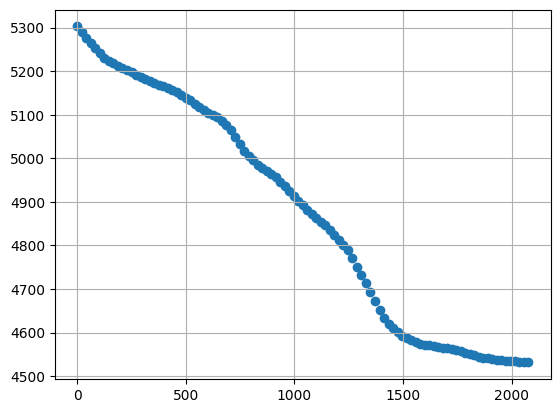

In [4]:
plt.figure()
plt.scatter(X, dem.at(X))
# plt.ylim(4400,)
plt.grid()

## Initialize the flow model

In [5]:
T = 273.15 - 0 #ice temperature (K), assumed isothermal
A = Constant(icepack.rate_factor(T))

opts = {
    'dirichlet_ids': [1] 
}

flow_model = icepack.models.ShallowIce()
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)
u = Function(Q).project(Constant(0))

## Invert for basal topography

In [11]:
params = {
    'model': flow_model,
    'solver': flow_solver,
    'mesh': mesh,
    'fluidity': A
}
    
inversion = solve_bed(K = 0.2, num_iterations = 40, timestep = 1/100, model_time = 1, surface = dem, 
                      thickness_guess = firedrake.Constant(200), velocity = u, accumulation = smb_adjusted, 
                      **params)

100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:24<00:00,  1.61it/s]


## Visualize the results

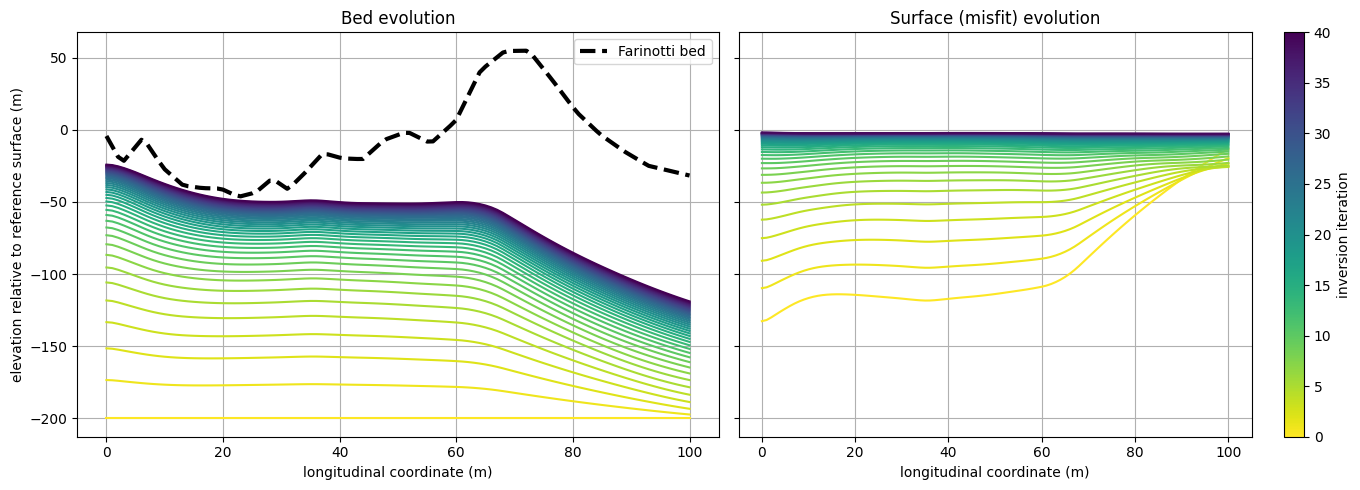

In [12]:
glacier_length = mesh.length
s_ref = inversion.s_ref

s_ref_array = np.array(s_ref.at(X, tolerance=1e-10))
farinotti_bed = firedrake.Function(Q).project(dem_old - thickness)
farinotti_bed_relative = farinotti_bed.at(X, tolerance=1e-10) - s_ref_array

# Outputs from the function
bed_evolution = inversion.bed_evolution
surface_evolution = inversion.surface_evolution

N = len(bed_evolution)
cmap = plt.get_cmap('viridis_r')
norm = Normalize(vmin=0, vmax=N - 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: Bed evolution
for i, entry in enumerate(bed_evolution):
    axes[0].plot(entry - s_ref_array, color=cmap(norm(i)))
axes[0].plot(farinotti_bed_relative, color='k', linestyle='dashed', linewidth=3, label='Farinotti bed')
axes[0].set_title('Bed evolution')
axes[0].set_xlabel('longitudinal coordinate (m)')
axes[0].set_ylabel('elevation relative to reference surface (m)')
axes[0].legend()
axes[0].grid()

# Right: Surface evolution
for i, entry in enumerate(surface_evolution):
    axes[1].plot(entry - s_ref_array, color=cmap(norm(i)))
axes[1].set_title('Surface (misfit) evolution')
axes[1].set_xlabel('longitudinal coordinate (m)')
axes[1].grid()

# Colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, ax=axes[1], orientation='vertical', label='inversion iteration')

plt.tight_layout()
plt.show()


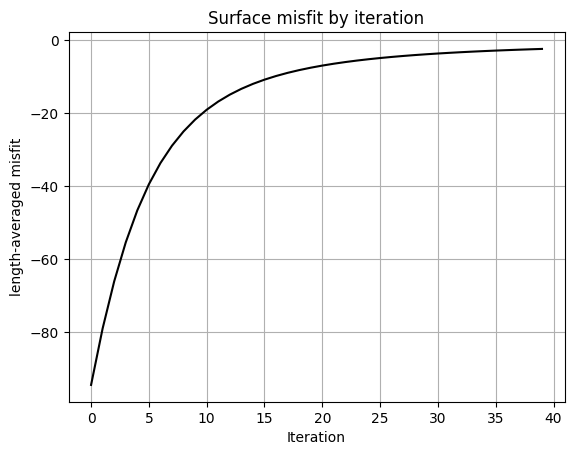

In [13]:
plt.figure()
plt.title('Surface misfit by iteration')
plt.plot(range(len(inversion.misfits)), inversion.misfits, color='k')
plt.ylabel('length-averaged misfit')
plt.xlabel('Iteration')
plt.grid(True, which='both')
# plt.ylim(0)  # Uncomment if you want the y-axis to start at 0
plt.show()

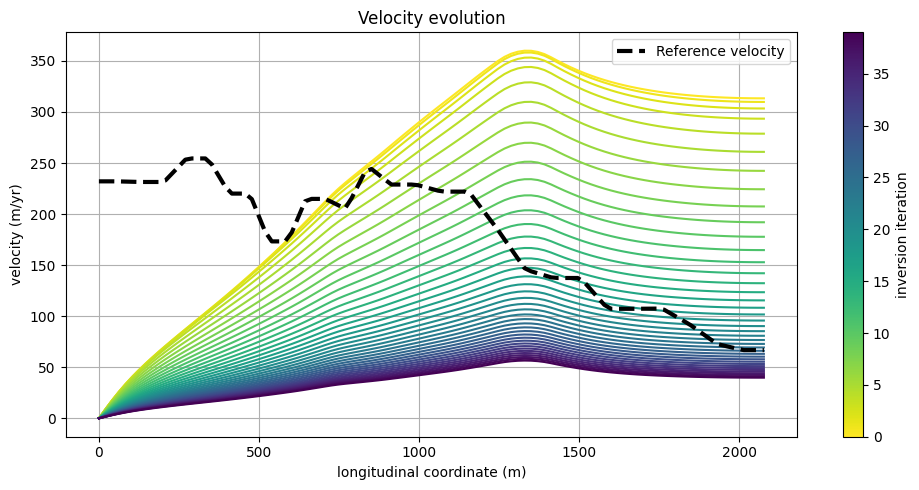

In [14]:
velocity_evolution = inversion.velocity_evolution
N = len(velocity_evolution)

cmap = plt.get_cmap('viridis_r')
norm = Normalize(vmin=0, vmax=N - 1)

fig, ax = plt.subplots(figsize=(10, 5))

for i, v_iter in enumerate(velocity_evolution):
    ax.plot(X, v_iter, color=cmap(norm(i)))

# Reference velocity (already precomputed on X)
velocity_ref = velocity.at(X, tolerance = 1e-10)
ax.plot(X, velocity_ref, color='k', linestyle='dashed', linewidth=3, label='Reference velocity')

ax.set_title('Velocity evolution')
ax.set_xlabel('longitudinal coordinate (m)')
ax.set_ylabel('velocity (m/yr)')
ax.grid()
ax.legend()

sm = ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, ax=ax, label='inversion iteration')

plt.tight_layout()
plt.show()

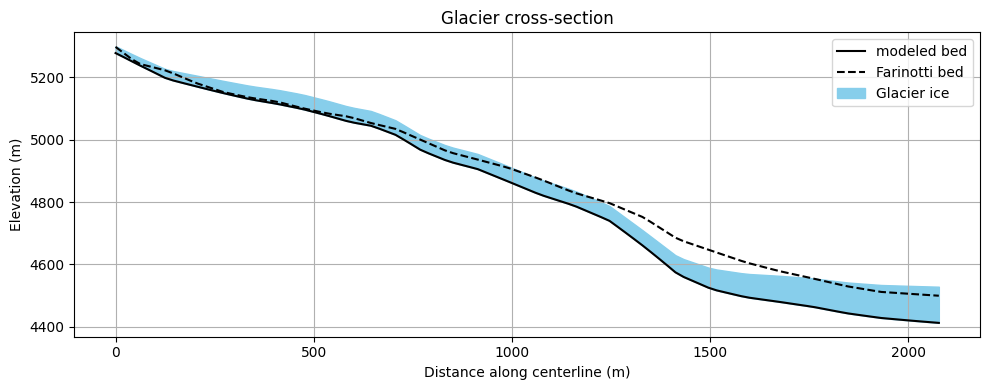

In [15]:
surface = surface_evolution[-1]
bed = bed_evolution[-1]

plt.figure(figsize = (10, 4))
plt.plot(X, bed, color = 'black', label = 'modeled bed')
plt.plot(X, farinotti_bed.at(X, tolerance = 1e-10), color = 'k', linestyle = 'dashed', label = 'Farinotti bed')
# plt.plot(X, surface, color = 'blue', label = 'surface')
plt.fill_between(X, bed, surface, color = 'skyblue', label = 'Glacier ice')

plt.xlabel('Distance along centerline (m)')
plt.ylabel('Elevation (m)')
plt.title('Glacier cross-section')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()